In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *
import glob

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "iframe"


import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame

from saturation.utils import *

In [3]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/07/14 13:43:20 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
24/07/14 13:43:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/14 13:43:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
base_path = "/data/saturation/thesis_run_20240130"

In [5]:
configs_df = create_configs_df(read_configs(base_path, spark))
configs_pdf = configs_df.toPandas()

In [6]:
# For stats, select only fields we care about, alias them
sample_percent = 0.25

data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
data = data.select(
    "simulation_id",
    F.col("n_craters_added_in_study_region").alias("ntot"),
    F.col("n_craters_in_study_region").alias("nobs"),
    F.col("center_to_center_nearest_neighbor_distance_mean").alias("mnnd"),
    "z",
    "za",
    F.col("areal_density").alias("ad"),
    F.log10(F.col("center_to_center_nearest_neighbor_distance_mean")).alias("log_mnnd"),
    F.log10(F.col("n_craters_in_study_region")).alias("log_nobs"),
    F.log10("n_craters_added_in_study_region").alias("log_ntot"),
)

# Join with configs to get simulation parameters
data_joined = join_configs(data, configs_df, spark).select(
    "*",
    (-F.col("slope")).alias("b"),
    F.col("min_rim_percentage").alias("mrp"),
    F.col("r_stat_multiplier").alias("erat"),
    F.col("effective_radius_multiplier").alias("rmult"),
)

# Rename some parameters
data = data_joined.sample(sample_percent).sort(F.rand()).cache()

In [7]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config_*.yaml"):
    for run_config in read_config(Path(config_file))["run_configurations"]:
        configs_dict.update(run_config)

## Plots of each variable by ntot

### Nobs vs ntot

In [51]:
def plot_overall(
    *,
    data: DataFrame,
    x_var: str,
    x_label: str,
    y_var: str,
    y_label: str,
    fig_name: str,
    x_axis_range: Tuple[float, float]=None,
    y_axis_range: Tuple[float, float]=None,
    n_target: int=None,
    color_by_var: str=None,
    color_by_label: str=None,
    color_bar_min: float=0.0,
    color_bar_max: float=0.0,
    min_ntot: int=100,
    title: str=None
):
    FONT_SIZE = 16
    FIGURE_SIZE = (8, 4)

    select_list = [x_var, y_var]
    if color_by_var:
        select_list.append(color_by_var)
    df_subset_spark = (
        data.where(F.col("ntot") > min_ntot)
            .select(*select_list)
    )
    if n_target:
        subset_sample_fraction = n_target / df_subset_spark.count()
        df_subset = df_subset_spark.sample(subset_sample_fraction).toPandas()
    else:
        df_subset = df_subset_spark.toPandas()
    
    fig = plt.figure(figsize=FIGURE_SIZE)
    ax = fig.add_subplot(111)

    if x_axis_range:
        ax.set_xlim(x_axis_range)

    if y_axis_range:
        ax.set_ylim(y_axis_range)

    if title:
        ax.set_title(title)
    
    scatterplot = ax.scatter(
        df_subset[x_var],
        df_subset[y_var],
        s=.25,
        c=df_subset[color_by_var] if color_by_var else None
    )

    if color_by_label:
        sm = plt.cm.ScalarMappable(cmap=plt.colormaps["cividis"])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label(label=color_by_label, size=FONT_SIZE)
        sm.set_clim(vmin=color_bar_min, vmax=color_bar_max)
    
    ax.set_xlabel(x_label, fontsize=FONT_SIZE)
    ax.set_ylabel(y_label, fontsize=FONT_SIZE)

    plt.savefig(f"figures/{fig_name}.png")
    plt.show()

    return ax, fig    

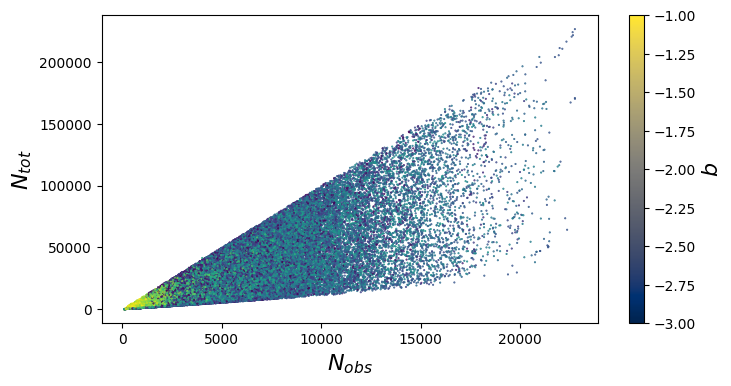

In [137]:
_ = plot_overall(
    data=data,
    n_target=50000,
    x_var="nobs",
    x_label="$N_{obs}$",
    y_var="ntot",
    y_label="$N_{tot}$",
    fig_name="nobs_by_ntot_overall",
    color_by_var="b",
    color_by_label="$b$",
    color_bar_min=-3.0,
    color_bar_max=-1.0
)

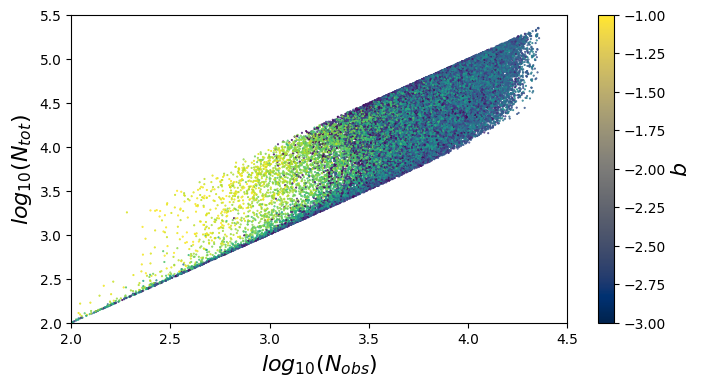

In [138]:
_ = plot_overall(
    data=data,
    n_target=50000,
    x_var="log_nobs",
    x_label="$log_{10}(N_{obs})$",
    x_axis_range=(2.0, 4.5),
    y_var="log_ntot",
    y_label="$log_{10}(N_{tot})$",
    y_axis_range=(2.0, 5.5),
    fig_name="log_nobs_by_log_ntot_overall",
    color_by_var="b",
    color_by_label="$b$",
    color_bar_min=-3.0,
    color_bar_max=-1.0
)

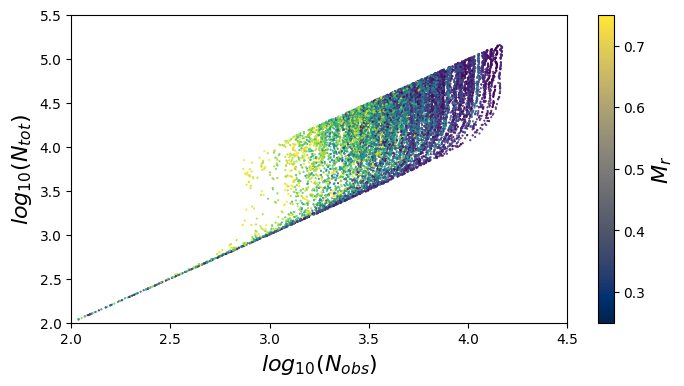

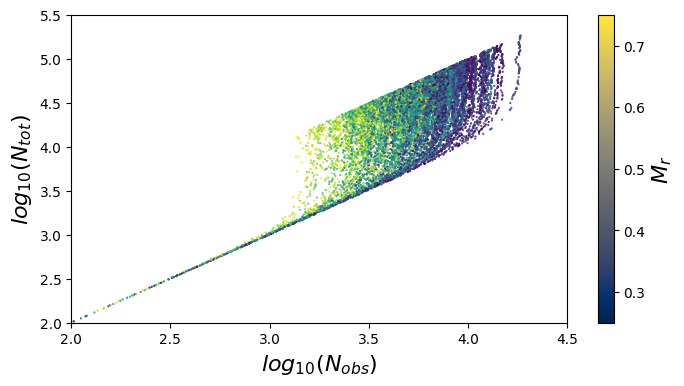

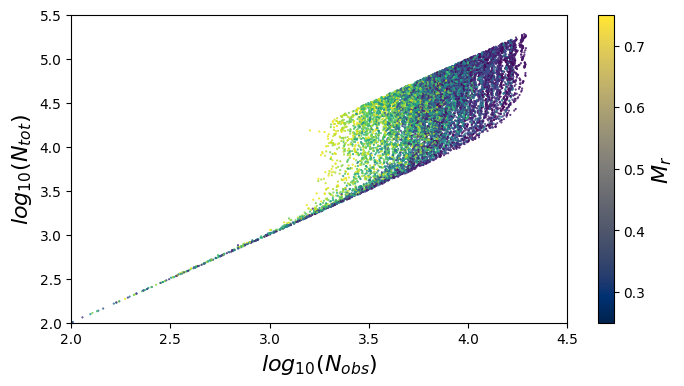

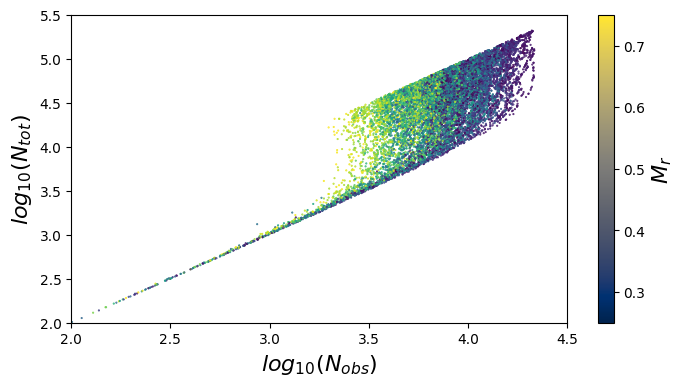

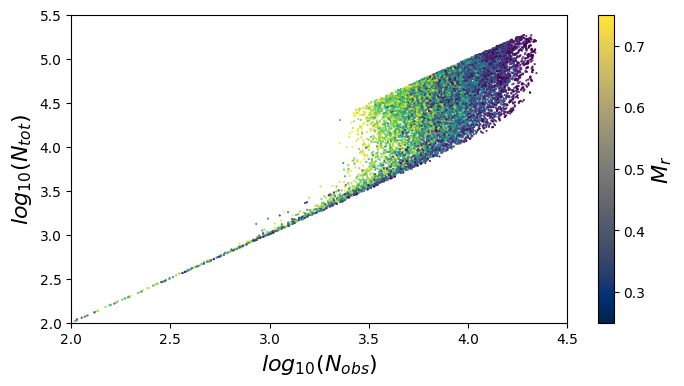

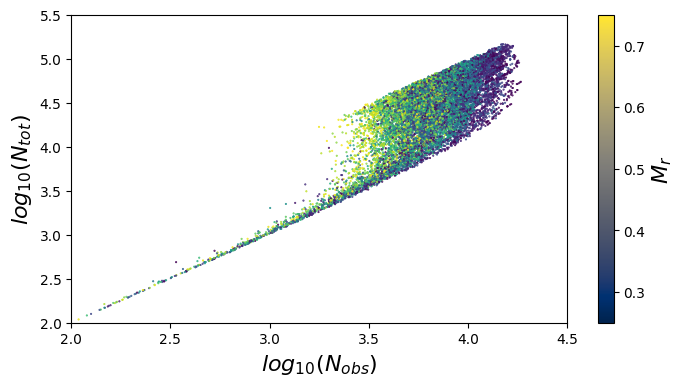

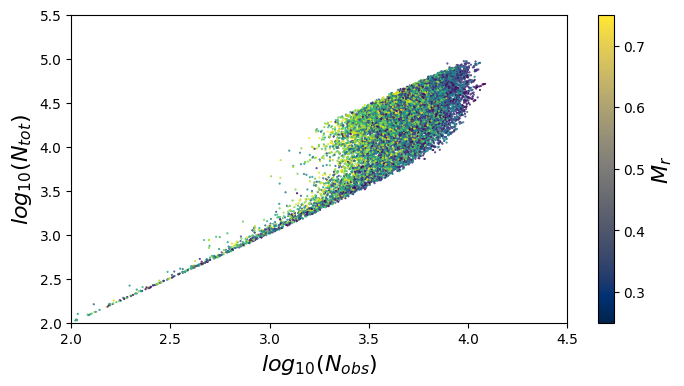

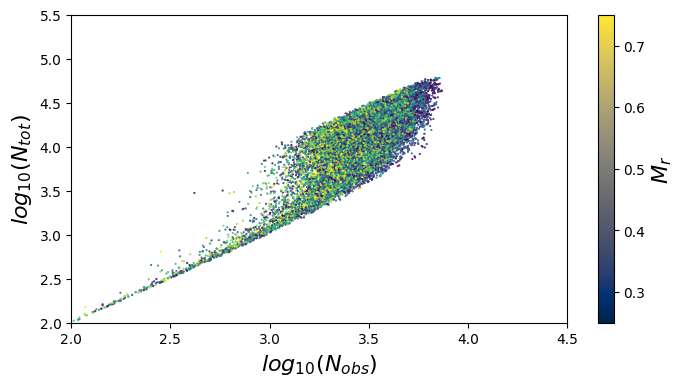

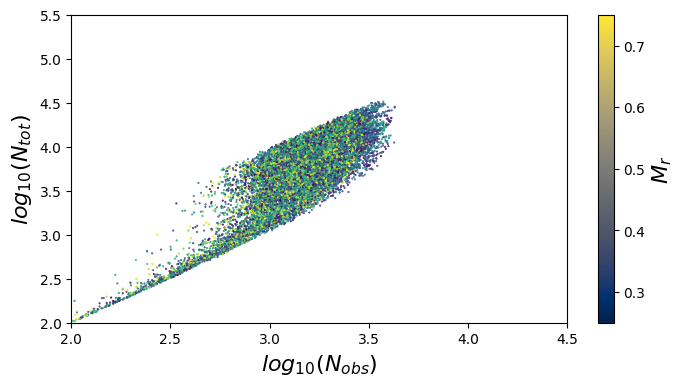

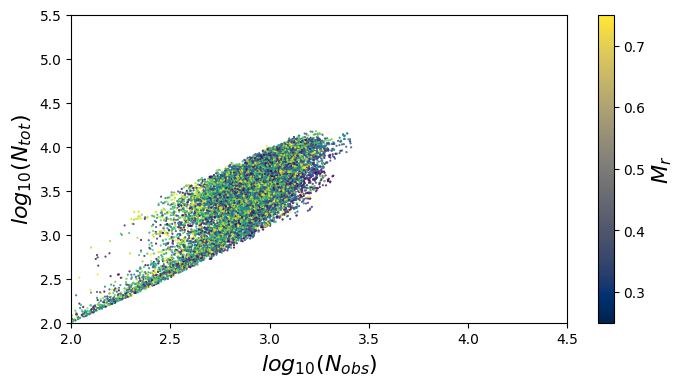

In [140]:
b_ranges = [
    (-3.0 + x * 0.2, -3.0 + x * 0.2 + 0.1)
    for x in range(10)
]

for b_min, b_max in b_ranges:
    _ = plot_overall(
        data=data.where(F.col("b").between(b_min, b_max)),
        n_target=15000,
        x_var="log_nobs",
        x_label="$log_{10}(N_{obs})$",
        x_axis_range=(2.0, 4.5),
        y_var="log_ntot",
        y_label="$log_{10}(N_{tot})$",
        y_axis_range=(2.0, 5.5),
        fig_name=f"log_nobs_by_log_ntot_b_{b_min:.1f}_{b_max:.1f}",
        color_by_var="mrp",
        color_by_label="$M_r$",
        color_bar_min=0.25,
        color_bar_max=0.75,
    )

In [141]:
# Let's find one of the weird outliers in (-3.0, -2.9)
b_min = -3.0
b_max = -2.9

data_subset = (
    data_joined.where(F.col("b").between(b_min, b_max))
               .sample(0.0001, seed=123)
).toPandas()

fig = px.scatter(
    data_subset,
    x="log_nobs",
    y="log_ntot",
    hover_data=data_subset.columns,
    size_max=1,
    width=800,
    height=400,
    color="mrp"
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}({N_{obs}})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log_{10}(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

In [142]:
# Sim ID 6170 has some of the outlier points
data_subset = data_joined.where(F.col("simulation_id") == 6170).toPandas()

fig = px.scatter(
    data_subset,
    y="log_nobs",
    x="log_ntot",
    hover_data=data_subset.columns,
    size_max=1,
    width=800,
    height=400,
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}({N_{obs}})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log_{10}(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

In [143]:
# Observation: the saturation values of nobs are indeed low for these simulations
# Hypothesis: at steeper slopes, destructive parameters have a larger impact on saturation nobs value
# sim ids with low n_obs: 6170, 5062, 7845
data_subset = data_joined.where(F.col("simulation_id").isin([6170, 5062, 7845])).select("erat", "rmult", "b", "mrp").distinct().toPandas()
data_subset

erat     rmult         b       mrp
0  13.893063  1.801950 -2.965454  0.723644
1  14.773572  1.896501 -2.965766  0.724020
2  14.647093  1.842018 -2.988220  0.718918

### Nobs vs mnnd

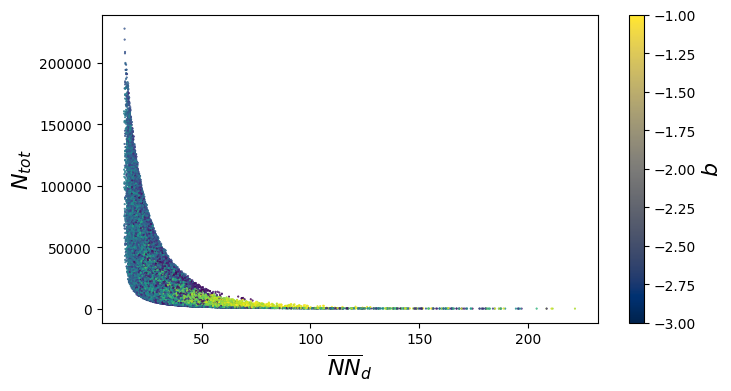

In [144]:
_ = plot_overall(
    data=data,
    n_target=50000,
    x_var="mnnd",
    x_label="$\overline{NN}_d$",
    y_var="ntot",
    y_label="$N_{tot}$",
    fig_name="mnnd_by_ntot_overall",
    color_by_var="b",
    color_by_label="$b$",
    color_bar_min=-3.0,
    color_bar_max=-1.0
)

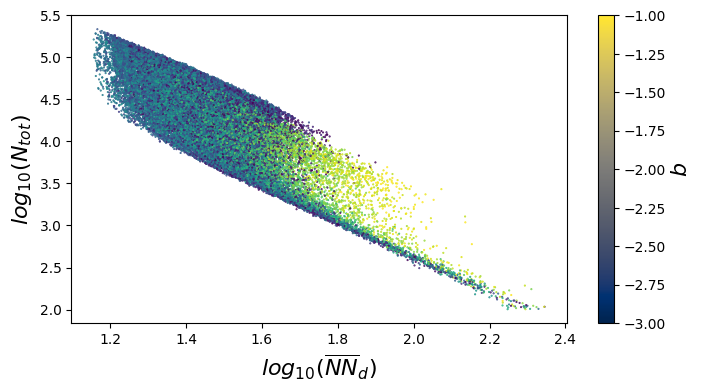

In [145]:
_ = plot_overall(
    data=data,
    n_target=50000,
    x_var="log_mnnd",
    x_label="$log_{10}(\overline{NN}_d)$",
    y_var="log_ntot",
    y_label="$log_{10}(N_{tot})$",
    fig_name="log_mnnd_by_log_ntot_overall",
    color_by_var="b",
    color_by_label="$b$",
    color_bar_min=-3.0,
    color_bar_max=-1.0
)

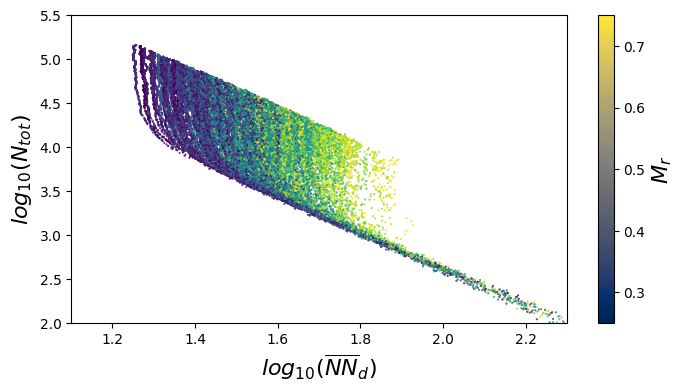

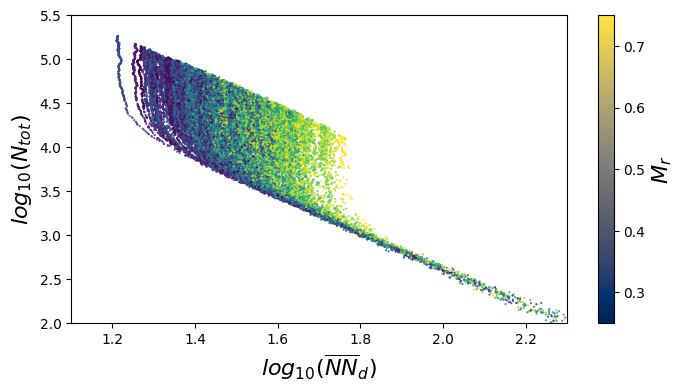

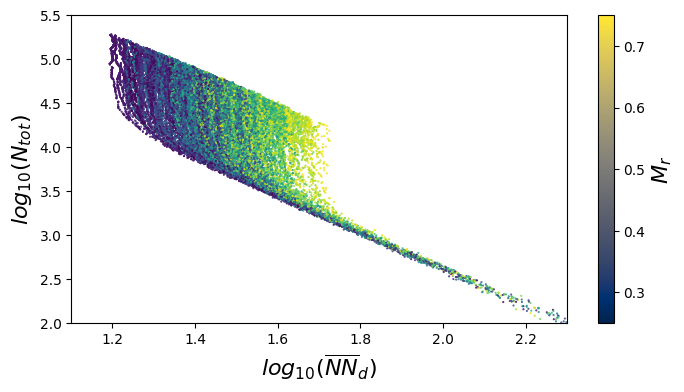

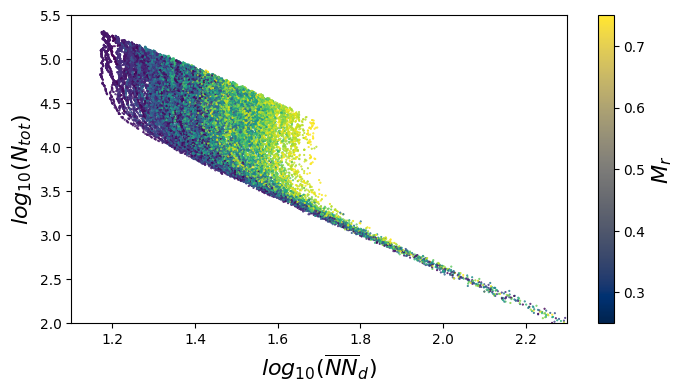

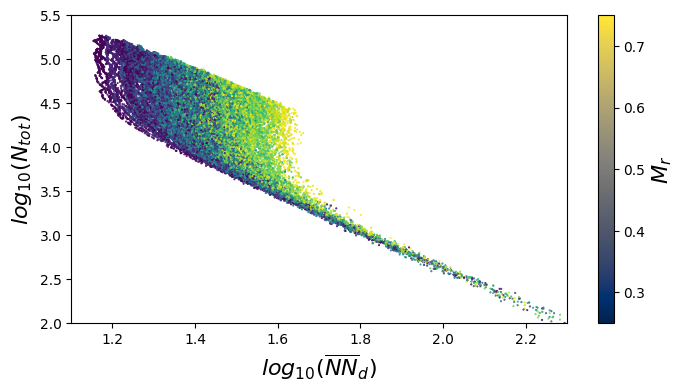

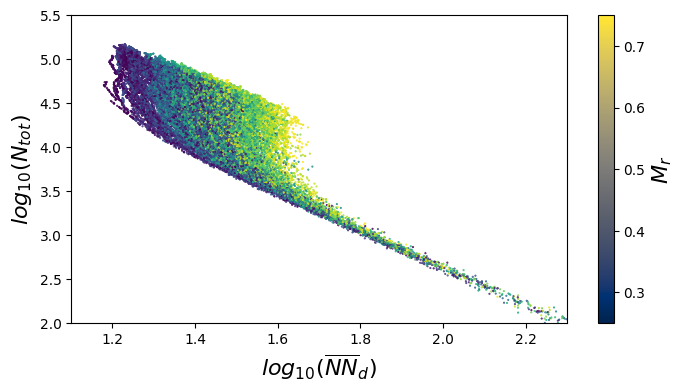

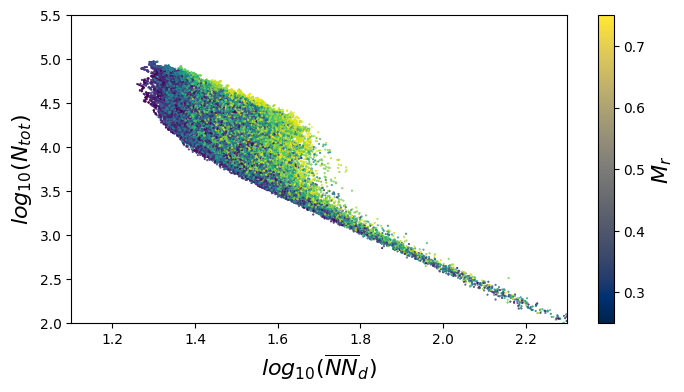

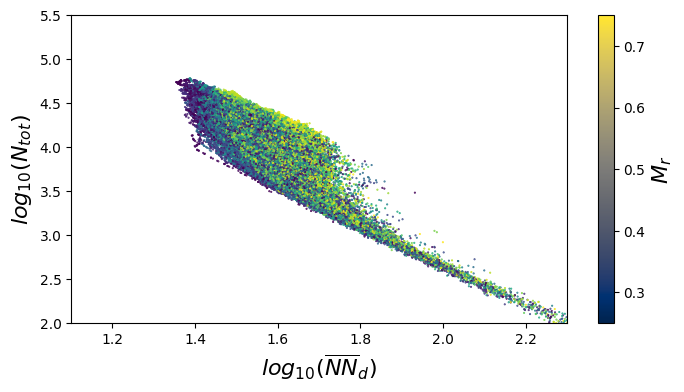

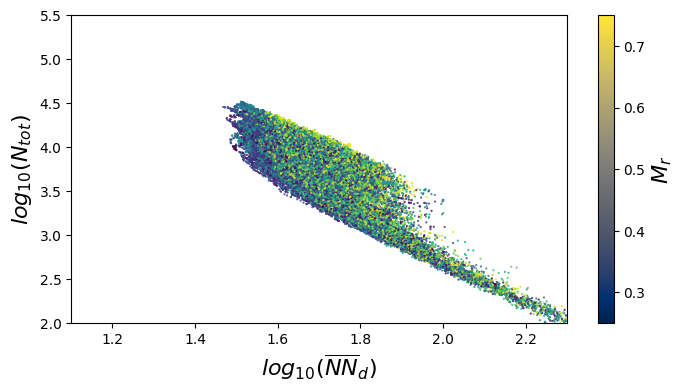

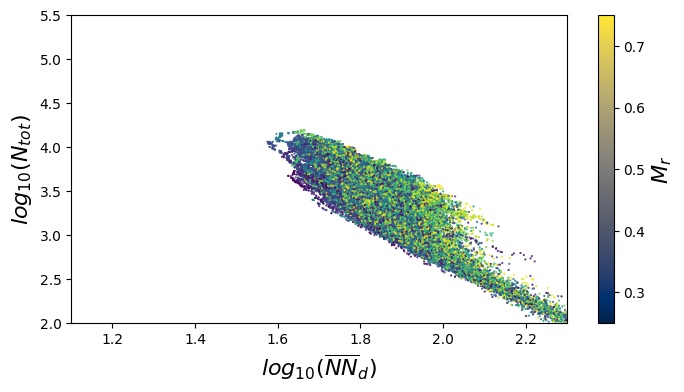

In [146]:
b_ranges = [
    (-3.0 + x * 0.2, -3.0 + x * 0.2 + 0.1)
    for x in range(10)
]

for b_min, b_max in b_ranges:
    _ = plot_overall(
        data=data.where(F.col("b").between(b_min, b_max)),
        n_target=50000,
        x_var="log_mnnd",
        x_label="$log_{10}(\overline{NN}_d)$",
        x_axis_range=(1.1, 2.3),
        y_var="log_ntot",
        y_label="$log_{10}(N_{tot})$",
        y_axis_range=(2.0, 5.5),
        fig_name=f"log_mnnd_by_log_ntot_b_{b_min:.1f}_{b_max:.1f}",
        color_by_var="mrp",
        color_by_label="$M_r$",
        color_bar_min=0.25,
        color_bar_max=0.75
    )

### Z and ZA by ntot

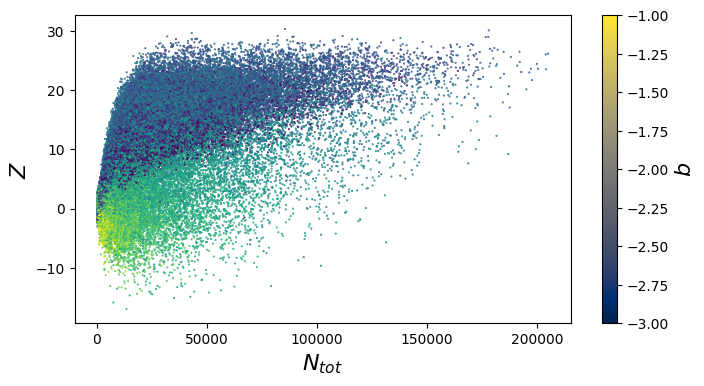

In [118]:
_ = plot_overall(
    data=data,
    n_target=50000,
    x_var="ntot",
    x_label="$N_{tot}$",
    y_var="z",
    y_label="$Z$",
    fig_name="z_by_ntot_overall",
    color_by_var="b",
    color_by_label="$b$",
    color_bar_min=-3.0,
    color_bar_max=-1.0
)

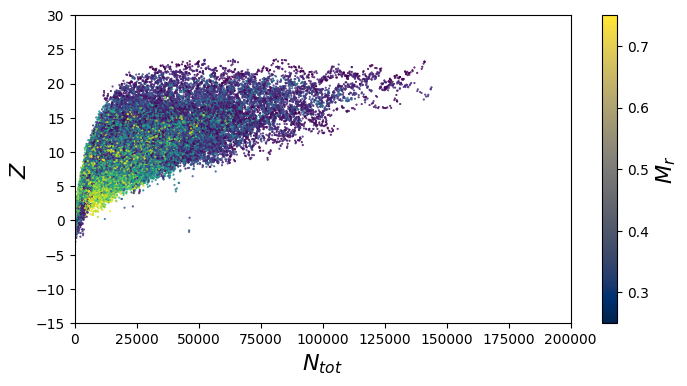

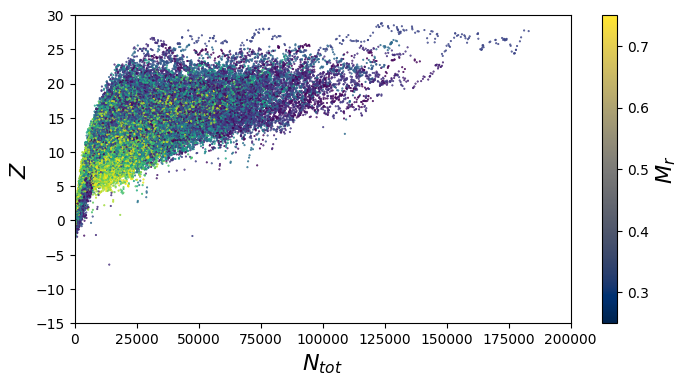

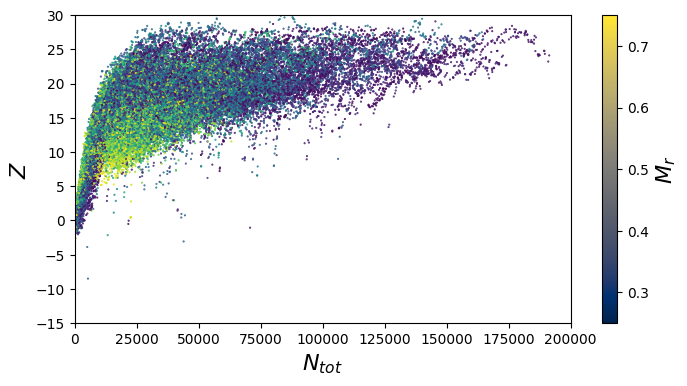

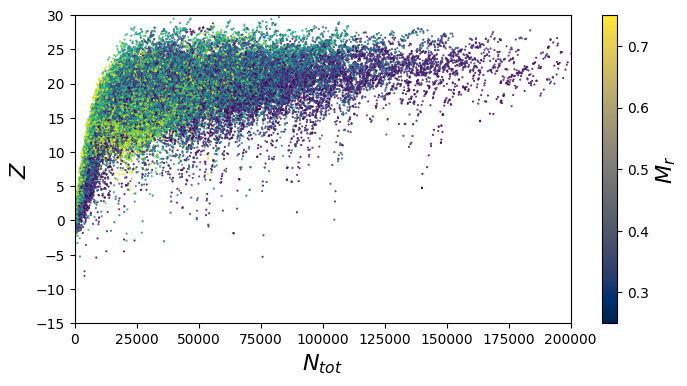

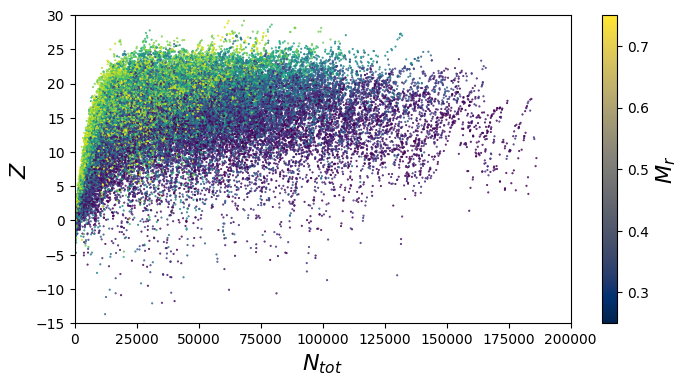

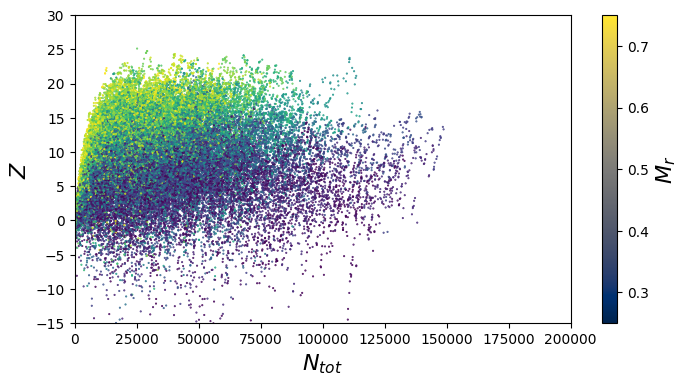

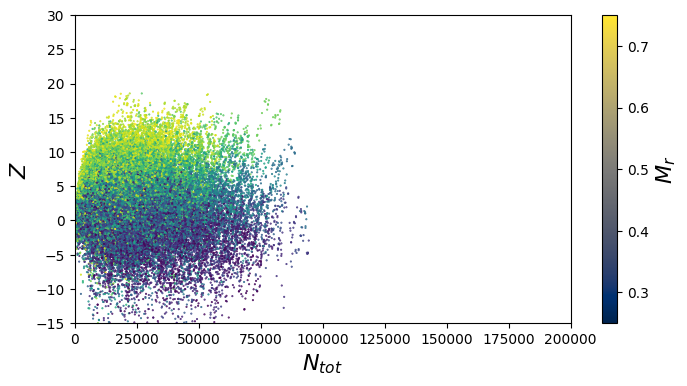

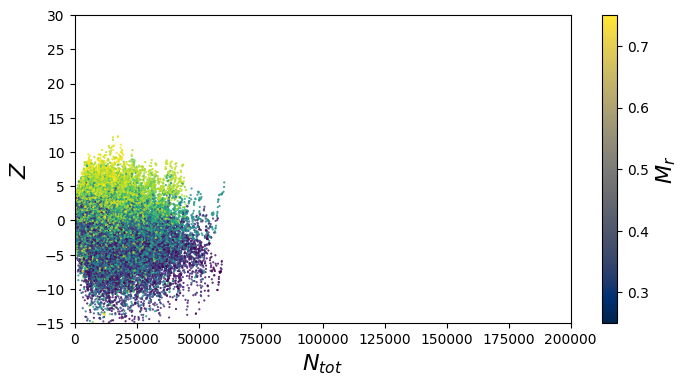

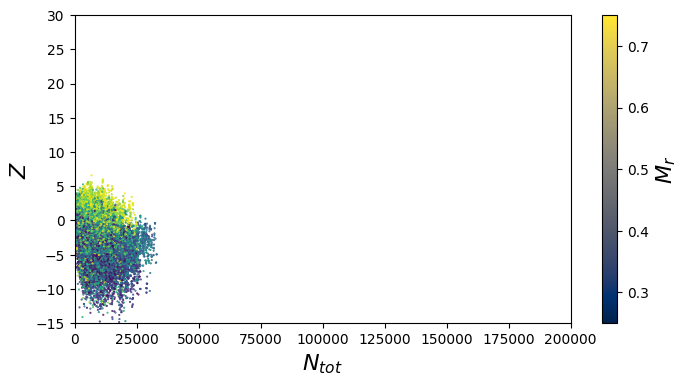

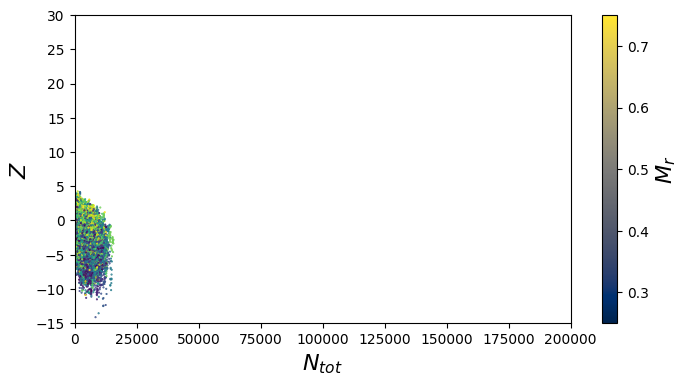

In [156]:
b_ranges = [
    (-3.0 + x * 0.2, -3.0 + x * 0.2 + 0.1)
    for x in range(10)
]

for b_min, b_max in b_ranges:
    _ = plot_overall(
        data=data.where(F.col("b").between(b_min, b_max)),
        n_target=50000,
        x_var="ntot",
        x_label="$N_{tot}$",
        x_axis_range=(0, 200000),
        y_var="z",
        y_label="$Z$",
        y_axis_range=(-15, 30),
        fig_name=f"z_by_ntot_b_{b_min:.1f}_{b_max:.1f}",
        color_by_var="mrp",
        color_by_label="$M_r$",
        color_bar_min=0.25,
        color_bar_max=0.75
    )

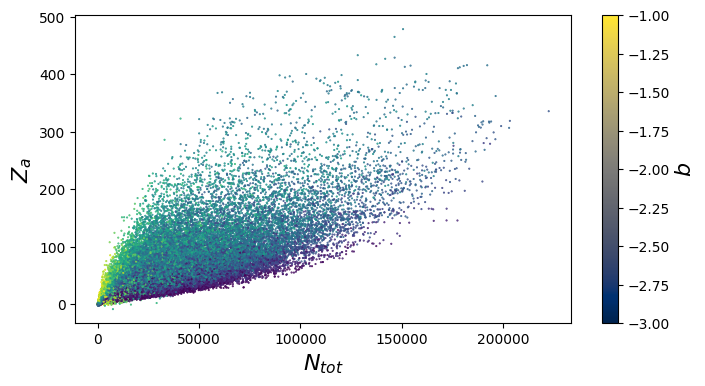

In [157]:
_ = plot_overall(
    data=data,
    n_target=50000,
    x_var="ntot",
    x_label="$N_{tot}$",
    y_var="za",
    y_label="$Z_a$",
    fig_name="za_by_ntot_overall",
    color_by_var="b",
    color_by_label="$b$",
    color_bar_min=-3.0,
    color_bar_max=-1.0
)

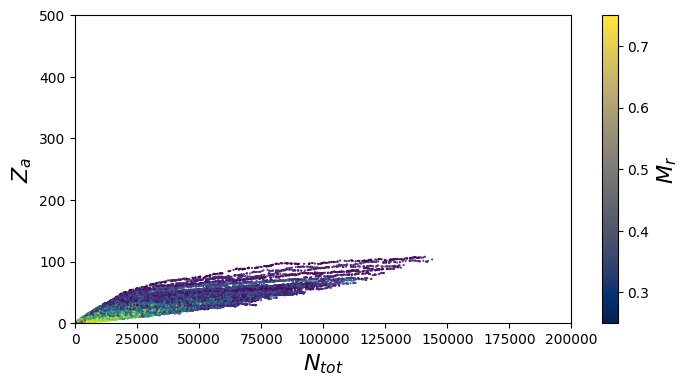

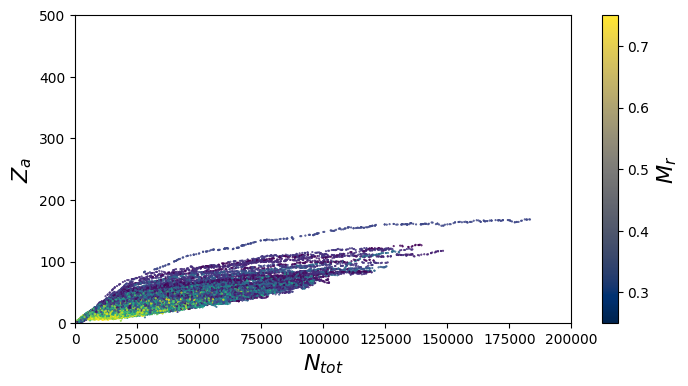

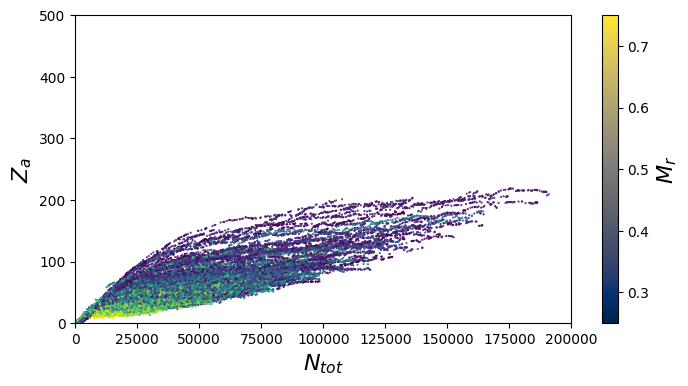

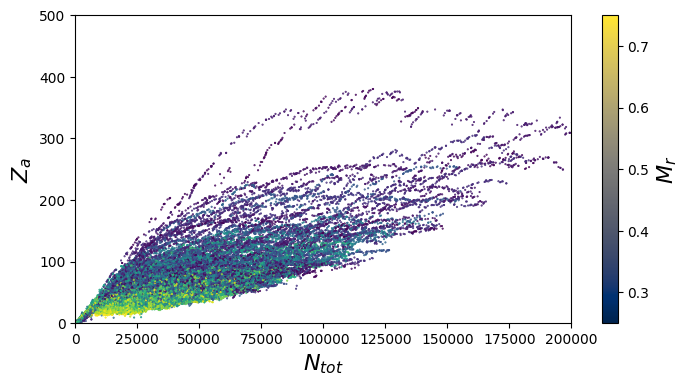

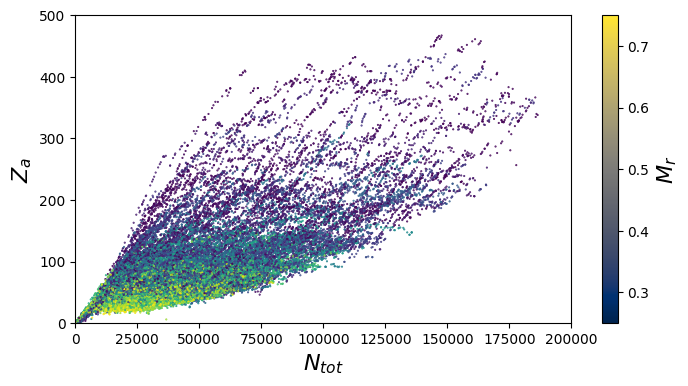

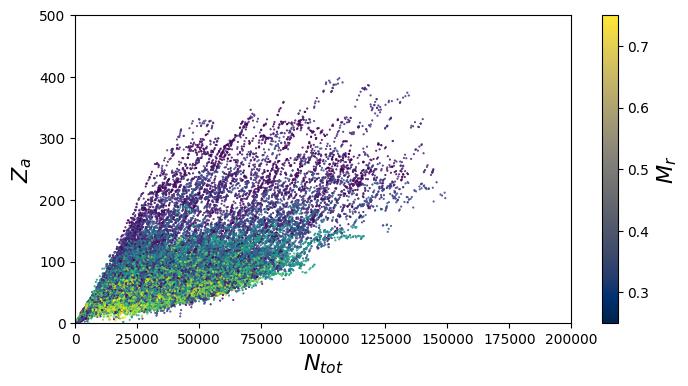

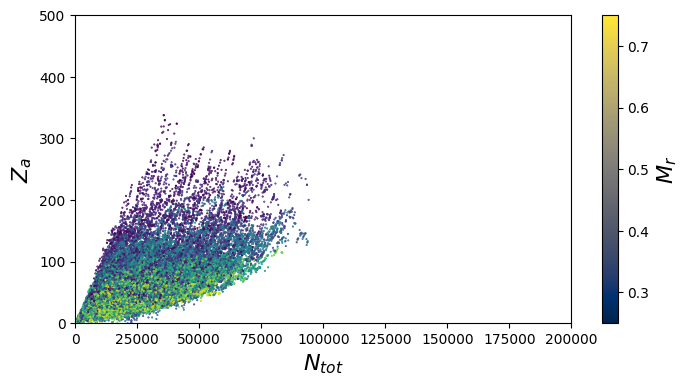

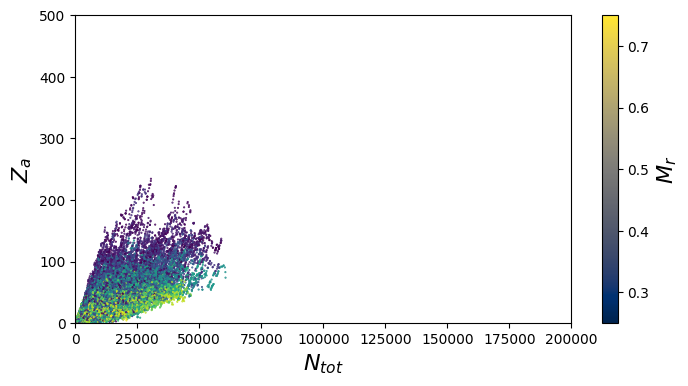

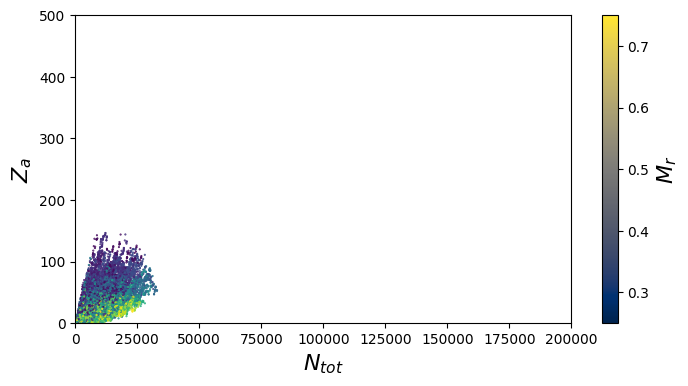

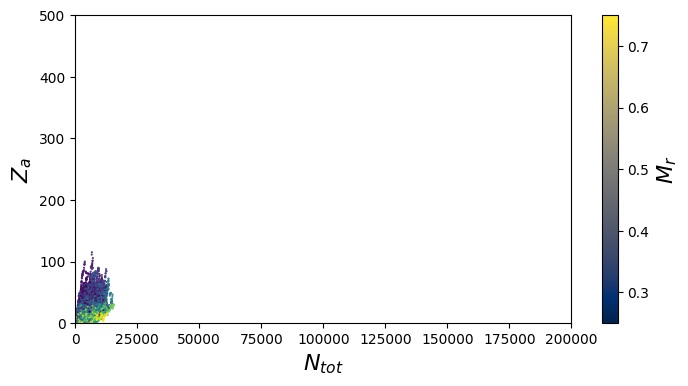

In [158]:
b_ranges = [
    (-3.0 + x * 0.2, -3.0 + x * 0.2 + 0.1)
    for x in range(10)
]

for b_min, b_max in b_ranges:
    _ = plot_overall(
        data=data.where(F.col("b").between(b_min, b_max)),
        n_target=50000,
        x_var="ntot",
        x_label="$N_{tot}$",
        x_axis_range=(0, 200000),
        y_var="za",
        y_label="$Z_a$",
        y_axis_range=(0, 500),
        fig_name=f"za_by_ntot_b_{b_min:.1f}_{b_max:.1f}",
        color_by_var="mrp",
        color_by_label="$M_r$",
        color_bar_min=0.25,
        color_bar_max=0.75
    )

### AD by ntot

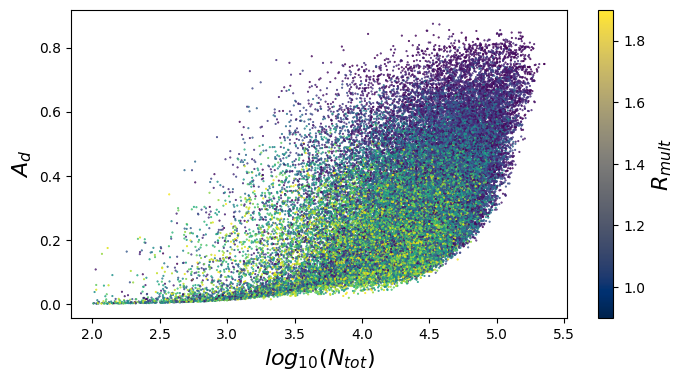

In [182]:
_ = plot_overall(
    data=data,
    n_target=50000,
    x_var="log_ntot",
    x_label="$log_{10}(N_{tot})$",
    y_var="ad",
    y_label="$A_d$",
    fig_name="ad_by_log_ntot_overall_rmult",
    color_by_var="rmult",
    color_by_label="$R_{mult}$",
    color_bar_min=1.1,
    color_bar_max=1.9
)

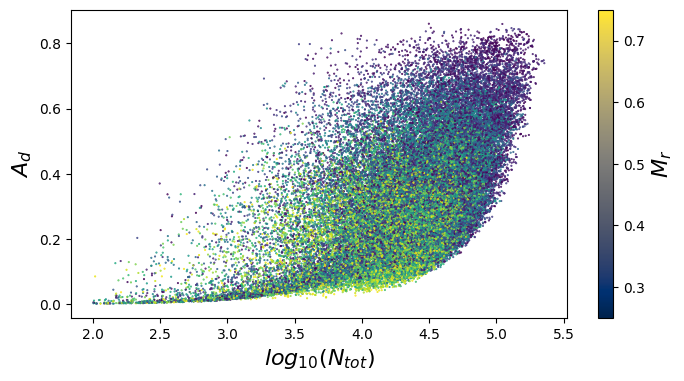

In [183]:
_ = plot_overall(
    data=data,
    n_target=50000,
    x_var="log_ntot",
    x_label="$log_{10}(N_{tot})$",
    y_var="ad",
    y_label="$A_d$",
    fig_name="ad_by_log_ntot_overall_mrp",
    color_by_var="mrp",
    color_by_label="$M_r$",
    color_bar_min=0.25,
    color_bar_max=0.75
)

In [253]:
data_subset = df[df.slope.between(2.9, 3.0)]

fig = px.scatter(
    data_subset,
    x="log_nobs",
    y="log_ntot",
    color="erat_norm",
    hover_data=["simulation_id", "slope", "nobs", "ntot", "mnnd", "ad", "z", "za"],
    size_max=1,
    width=1000,
    height=500
)
fig.update_traces(marker={"size":3})
fig.show()

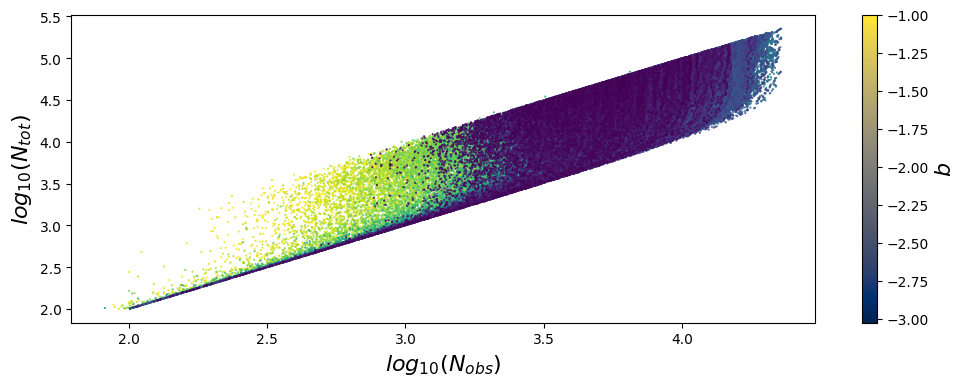

In [59]:
font_size = 16

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)

scatterplot = ax.scatter(
    df.log_nobs,
    df.log_ntot,
    s=.25,
    c=-df.slope
)
sm = plt.cm.ScalarMappable(cmap=plt.colormaps["cividis"])
sm.set_clim(vmin=-1.0, vmax=-3.0 + 0.25)
cbar = plt.colorbar(sm, ax=ax)

cbar.set_label(label="$b$", size=font_size)

ticks = [-1 - x / 4 for x in range(0, 9)]
cbar.set_ticks(ticks)

ax.set_xlabel("$log_{10}(N_{obs})$", fontsize=font_size)
ax.set_ylabel("$log_{10}(N_{tot})$", fontsize=font_size)
plt.show()

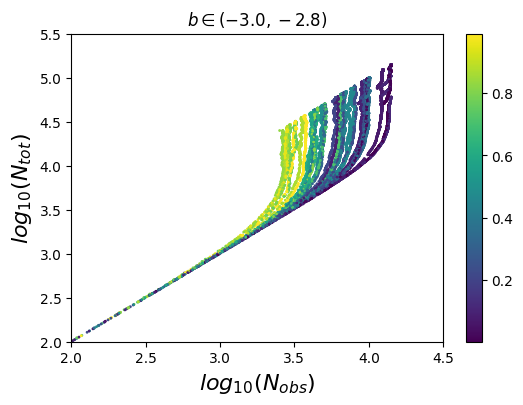

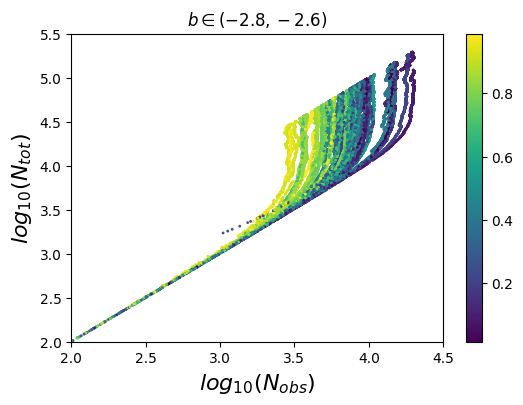

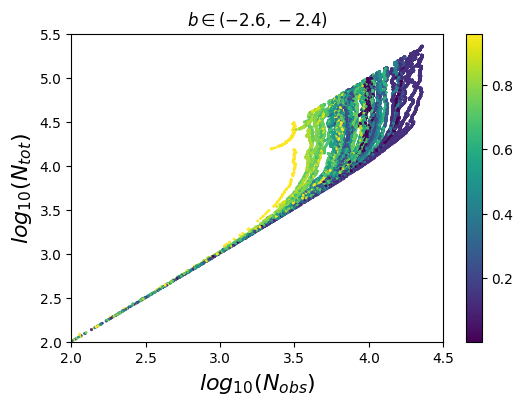

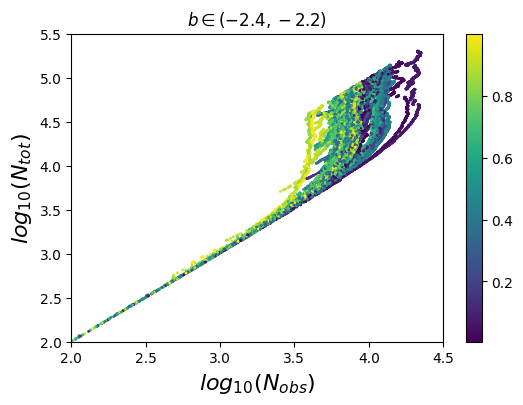

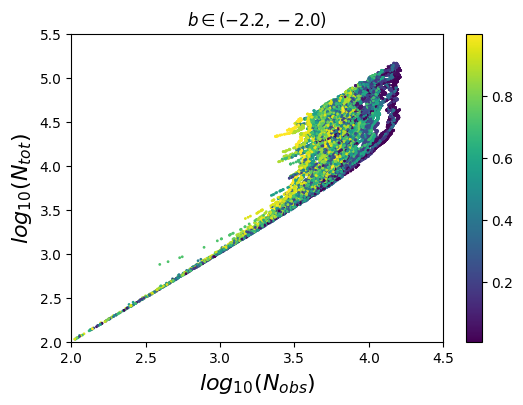

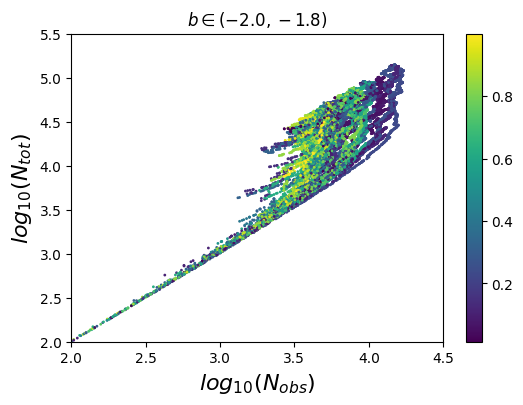

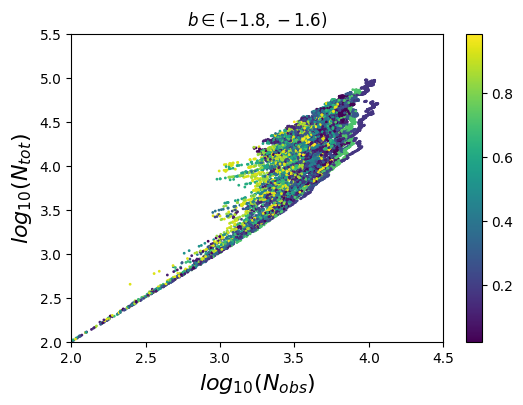

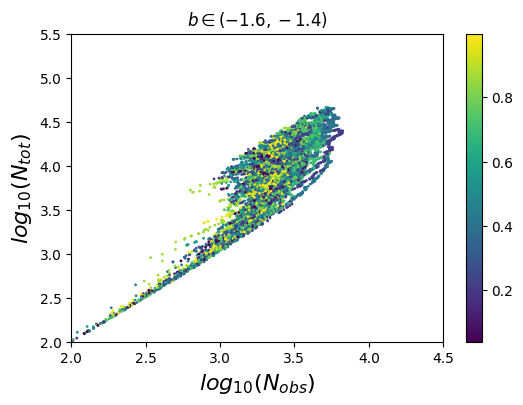

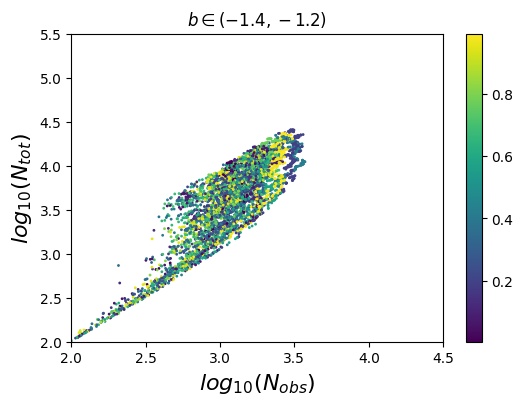

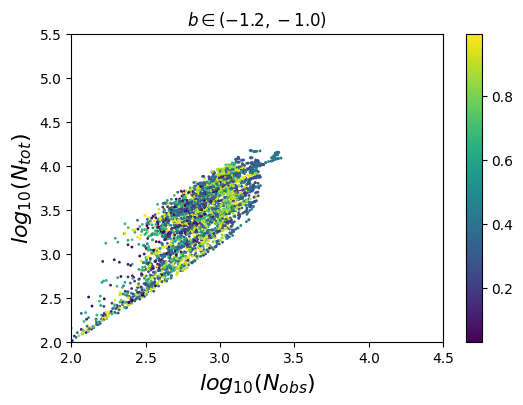

In [256]:
font_size = 16

slope_min = -3
slope_max = -1
slope_delta = 0.2
steps = int((slope_max - slope_min) / slope_delta)
slopes = [
    (slope_min + x * slope_delta, slope_min + (x + 1) * slope_delta)
    for x in range(0, steps)
]

for slope_lower, slope_upper in slopes:
    data_subset = df[df.slope.between(-slope_upper, -slope_lower)]
    
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    
    scatterplot = ax.scatter(
        data_subset.log_nobs,
        data_subset.log_ntot,
        s=1,
        c=(data_subset.mrp_norm )
    )
    cbar = plt.colorbar(scatterplot)
    
    ax.set_title(f"$b \in ({slope_lower:.1f}, {slope_upper:.1f})$")
    ax.set_xlabel("$log_{10}(N_{obs})$", fontsize=font_size)
    ax.set_ylabel("$log_{10}(N_{tot})$", fontsize=font_size)
    ax.set_xlim(2, 4.5)
    ax.set_ylim(2, 5.5)
    plt.show()

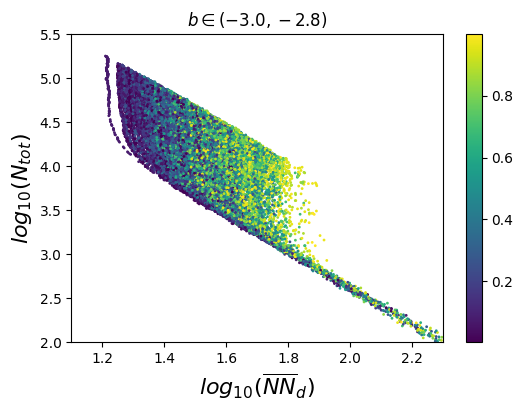

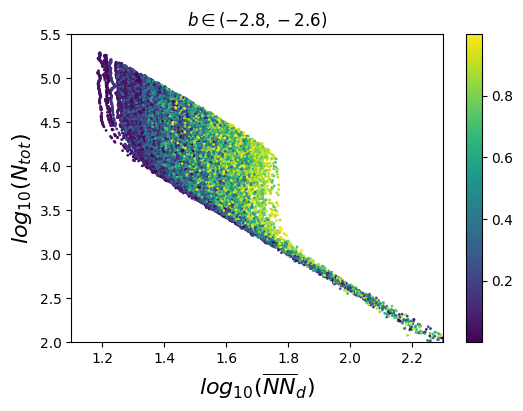

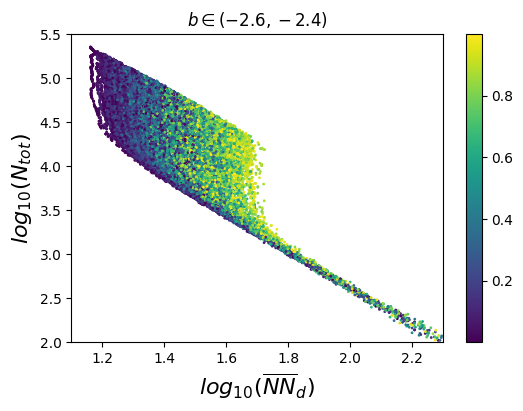

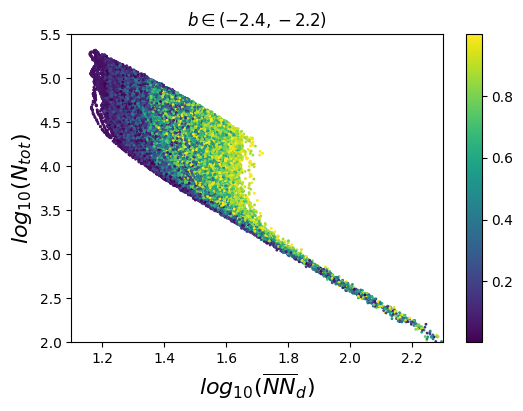

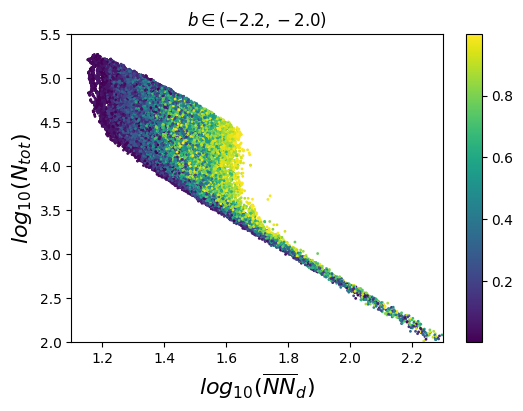

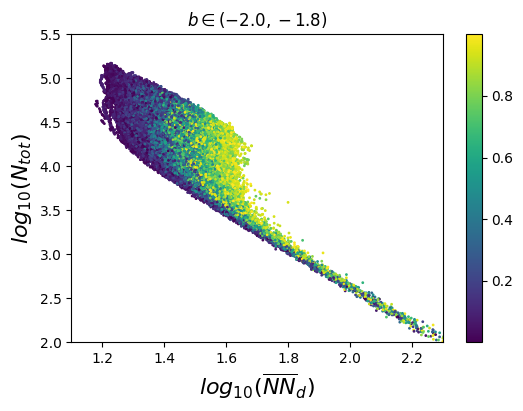

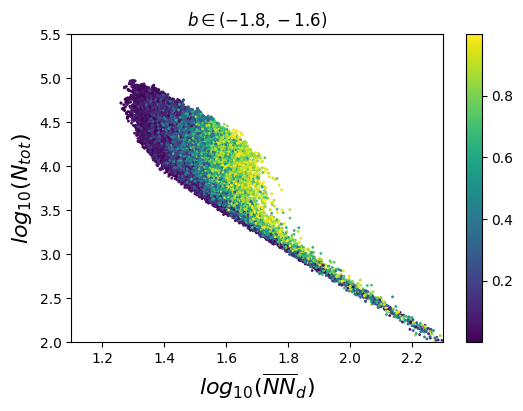

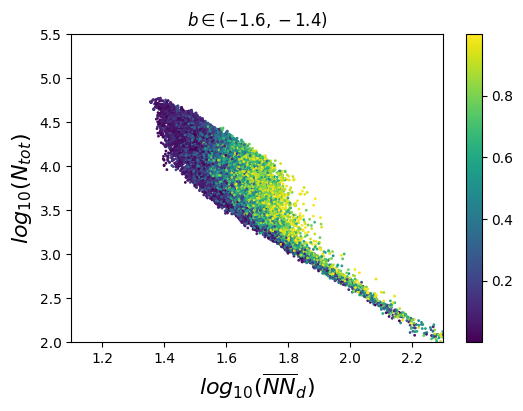

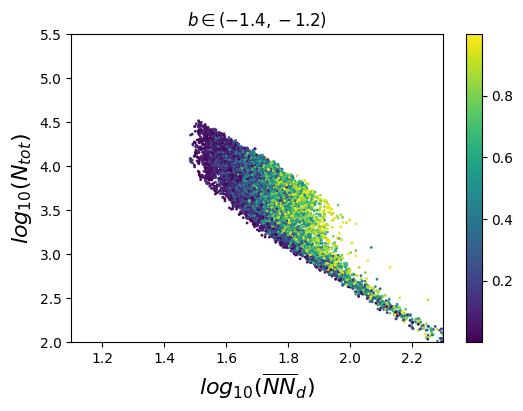

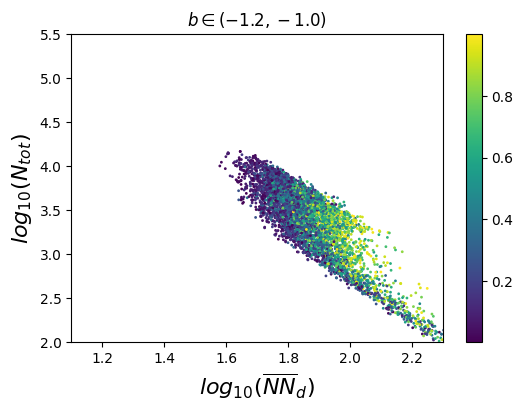

In [120]:
font_size = 16

slope_min = -3
slope_max = -1
slope_delta = 0.2
steps = int((slope_max - slope_min) / slope_delta)
slopes = [
    (slope_min + x * slope_delta, slope_min + (x + 1) * slope_delta)
    for x in range(0, steps)
]

for slope_lower, slope_upper in slopes:
    data_subset = df[df.slope.between(-slope_upper, -slope_lower)]
    
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    
    scatterplot = ax.scatter(
        data_subset.log_mnnd,
        data_subset.log_ntot,
        s=1,
        c=data_subset.rmult_norm
    )
    cbar = plt.colorbar(scatterplot)
    
    ax.set_title(f"$b \in ({slope_lower:.1f}, {slope_upper:.1f})$")
    ax.set_xlabel("$log_{10}(\overline{NN}_d)$", fontsize=font_size)
    ax.set_ylabel("$log_{10}(N_{tot})$", fontsize=font_size)
    ax.set_xlim(1.1, 2.3)
    ax.set_ylim(2, 5.5)
    plt.show()

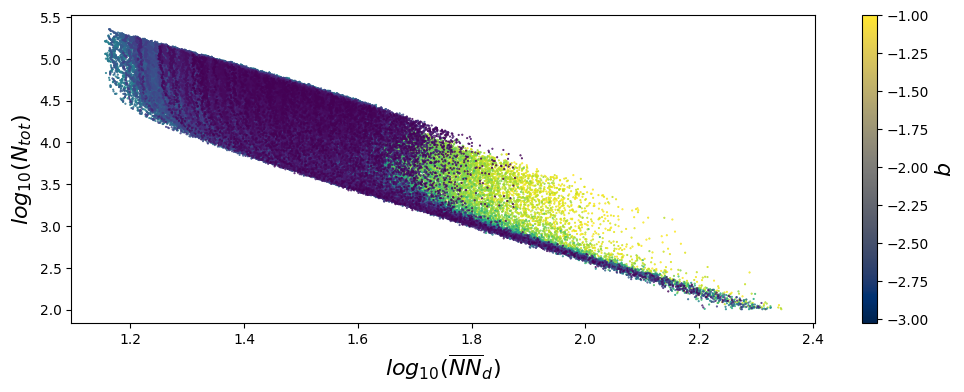

In [49]:
font_size = 16

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)

scatterplot = ax.scatter(
    df.log_mnnd,
    df.log_ntot,
    s=.25,
    c=-df.slope
)
sm = plt.cm.ScalarMappable(cmap=plt.colormaps["cividis"])
sm.set_clim(vmin=-1.0, vmax=-3.0 + 0.25)
cbar = plt.colorbar(sm, ax=ax)

cbar.set_label(label="$b$", size=font_size)

ticks = [-1 - x / 4 for x in range(0, 9)]
cbar.set_ticks(ticks)

ax.set_xlabel("$log_{10}(\overline{NN}_d)$", fontsize=font_size)
ax.set_ylabel("$log_{10}(N_{tot})$", fontsize=font_size)
plt.show()

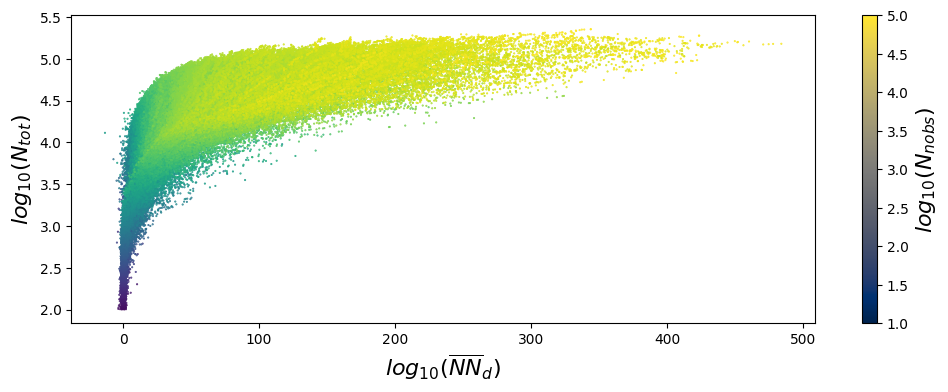

In [57]:
font_size = 16

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)

scatterplot = ax.scatter(
    df.za,
    df.log_ntot,
    s=.25,
    c=df.log_nobs
)
sm = plt.cm.ScalarMappable(cmap=plt.colormaps["cividis"])
sm.set_clim(vmin=1, vmax=5)
cbar = plt.colorbar(sm, ax=ax)

cbar.set_label(label="$log_{10}(N_{nobs})$", size=font_size)

# ticks = [-1 - x / 4 for x in range(0, 9)]
# cbar.set_ticks(ticks)

ax.set_xlabel("$log_{10}(\overline{NN}_d)$", fontsize=font_size)
ax.set_ylabel("$log_{10}(N_{tot})$", fontsize=font_size)
plt.show()

In [ ]:
# Trying a range selector
to_show = df.copy()
to_show["slope_selector"] = ((to_show.slope - 1) * 10).astype("int") / 10 + 1
to_show = to_show.sort_values("slope_selector")
to_show["index"] = range(to_show.shape[0])

range_x = [to_show.log_n_craters_in_study_region.min(), to_show.log_n_craters_in_study_region.max()]
range_y = [to_show.log_n_craters_added_in_study_region.min(), to_show.log_n_craters_added_in_study_region.max()]

fig = px.scatter(
    to_show,
    x="log_n_craters_in_study_region",
    y="log_n_craters_added_in_study_region",
    color="log_n_craters_in_study_region",
    hover_data=["slope", "n_craters_added_in_study_region"],
    size_max=1,
    animation_frame="slope_selector",
    animation_group="index",
    range_x=range_x,
    range_y=range_y,
    width=1000,
    height=500
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(N_{obs})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

In [489]:
def calculate_expected_destructive_effects(
    alpha: float,
    x_min_dist: float,
    x_max_dist: float,
    x_min_integral: float,
    x_max_integral: float,
) -> float:
    return (alpha * x_min_dist**alpha)/(1 - (x_min_dist/x_max_dist)**alpha) * (x_max_integral**(2 - alpha) - x_min_integral**(2-alpha))/(2-alpha)

def calculate_proportion_destructive_effects(
    alpha: float,
    erat: float
) -> float:
    r_stat = 5
    
    return calculate_expected_proportion_destructive_effects(
                alpha,
                r_stat/erat,
                1000,
                r_stat/erat,
                5) / calculate_expected_proportion_destructive_effects(
                    alpha,
                    r_stat/erat,
                    1000,
                    r_stat/erat,
                    1000)

In [530]:
min_slope = 1
max_slope = 5
min_erat = 6
max_erat = 15
n_steps = 25

sample_points = [
    (
        min_slope + slope_counter * (max_slope - min_slope)/n_steps,
        min_erat + erat_counter * (max_erat - min_erat)/n_steps
    )
    for erat_counter in range(n_steps + 1)
    for slope_counter in range(n_steps + 1)
]
sample_df = pd.DataFrame(sample_points, columns=["slope", "erat"])
sample_df["prop"] = calculate_proportion_destructive_effects(
    sample_df.slope,
    sample_df.erat
)

In [531]:
px.scatter_3d(
    sample_df,
    x="slope",
    y="erat",
    z="prop"
)

24/06/05 19:01:13 WARN TransportChannelHandler: Exception in connection from /192.168.1.14:33217
java.io.IOException: Connection timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:339)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:293)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:268)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:425)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:259)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptim

In [462]:
n_trials = 10000000
r_min = 5

In [463]:
from saturation.distributions import ParetoProbabilityDistribution

slope = 3
erat = 6

distribution = ParetoProbabilityDistribution(cdf_slope=slope, x_min=r_min/erat, x_max=1000)
u = np.random.random(n_trials)
dest_lower = np.sum([x**2 for x in distribution.pullback(u) if x > r_min/erat and x < r_min])
dest_total = np.sum([x**2 for x in distribution.pullback(u)])
dest_lower / dest_total

0.8281558412855428

In [464]:
slope = 2.05
erat = 6

distribution = ParetoProbabilityDistribution(cdf_slope=slope, x_min=r_min/erat, x_max=1000)
u = np.random.random(n_trials)
dest_lower = np.sum([x**2 for x in distribution.pullback(u) if x > r_min/erat and x < r_min])
dest_total = np.sum([x**2 for x in distribution.pullback(u)])
dest_lower / dest_total

0.2812169119150622

In [465]:
slope = 3
erat = 15

distribution = ParetoProbabilityDistribution(cdf_slope=slope, x_min=r_min/erat, x_max=1000)
u = np.random.random(n_trials)
dest_lower = np.sum([x**2 for x in distribution.pullback(u) if x > r_min/erat and x < r_min])
dest_total = np.sum([x**2 for x in distribution.pullback(u)])
dest_lower / dest_total

0.9331466275373493

In [466]:
slope = 2.05
erat = 15

distribution = ParetoProbabilityDistribution(cdf_slope=slope, x_min=r_min/erat, x_max=1000)
u = np.random.random(n_trials)
dest_lower = np.sum([x**2 for x in distribution.pullback(u) if x > r_min/erat and x < r_min])
dest_total = np.sum([x**2 for x in distribution.pullback(u)])
dest_lower / dest_total

0.4307895466080751

In [284]:
erat = 6
steep_slope = 3
shallow_slope = 2.05

(calculate_expected_destructive_effects(steep_slope, 100/erat, 100) / calculate_expected_destructive_effects(steep_slope, 5, 1000)) / (calculate_expected_destructive_effects(shallow_slope, 100/erat, 100) / calculate_expected_destructive_effects(shallow_slope, 5, 1000))

2.2271889845090045

In [283]:
erat = 15
steep_slope = 3
shallow_slope = 2.05

(calculate_expected_destructive_effects(steep_slope, 100/erat, 100) / calculate_expected_destructive_effects(steep_slope, 5, 1000)) / (calculate_expected_destructive_effects(shallow_slope, 100/erat, 100) / calculate_expected_destructive_effects(shallow_slope, 5, 1000))

1.717737980814522

In [373]:
def get_percent_up_to_erat(erat: float, alpha: float):
    x = erat
    x_min = 1
    
    return (1 - (x_min/x)**alpha) - (1 - (x_min/(x / erat))**alpha)

In [376]:
get_percent_up_to_erat(6, 3.05) / get_percent_up_to_erat(6, 2.05)

1.0217160654892068

In [377]:
get_percent_up_to_erat(15, 3.05) / get_percent_up_to_erat(15, 2.05)

1.0036369618167578

In [361]:
x = 100
erat = 6
alpha = 3

((x/erat)**-alpha - x**-alpha) / ((x/erat)**(-alpha+1) - x**(-alpha+1))

0.06142857142857142

In [362]:
x = 100
erat = 15
alpha = 3

((x/erat)**-alpha - x**-alpha) / ((x/erat)**(-alpha+1) - x**(-alpha+1))

0.15062499999999998

In [370]:
x = 100
erat = 6
alpha = 3

# Probability of R > x
(x**-alpha / (x/erat)**-alpha) / (x**(-alpha+1) / (x/erat)**(-alpha+1))

0.16666666666666666

In [368]:
alpha = 2
(x**-alpha / (x/erat)**-alpha)

0.027777777777777783

In [393]:
rs = 10
rm = rs / 15

((rm**-3 - rs**-3)/rm**-3) / ((rm**-2 - rs**-2) / rm**-2)

1.0041666666666667

In [386]:
(rm**-2 - rs**-2)

0.35

In [389]:
rm**-3

0.008

In [390]:
rm**-2

0.04

In [394]:
def cdf(x_min, x, alpha):
    return 1 - (x_min/x)**alpha

In [412]:
erat = 6
alpha = 3

(cdf(10, 500, alpha) - cdf(10, 500/erat, alpha)) / cdf(10, 500/erat, alpha)

0.001722977304782608

In [415]:
cdf(10, 11, alpha)

0.24868519909842235

In [411]:
erat = 6
alpha = 2

(cdf(10, 500, alpha) - cdf(10, 500/erat, alpha)) / cdf(10, 500/erat, alpha)

0.014204545454545466

In [403]:
erat = 15

cdf(10, 500/erat, 3) - cdf(100, 500, 3)

-0.019000000000000017